# k-means Clustering

## Libraries and settings

In [14]:
# Libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Current working directory
print('\nCurrent working directory:', os.getcwd())


Current working directory: /Users/bastian/vs_code/wine_analysis/notebooks


## Clusters in the wine data

### Import the wine data

In [15]:
df_orig = pd.read_csv("../data/enriched/wines_with_abv.csv")[[ 'web-scraper-order',
            'name',
            'price',
            'bio',
            'non_alcoholic',
            'premium',
            'quantity_in_cl',
            'price_per_10cl',
            'consumption_in_l',
            'ABV',
            ]]

# Rename variable 'web-scraper-order' to 'apmt_id'
df_orig = df_orig.rename(columns={'web-scraper-order': 'id'})

# Remove missing values
df = df_orig.dropna()
df.head(5)

# Remove duplicates
df = df.drop_duplicates()

print(df.shape)
df.head(5)

(300, 10)


,id,name,price,bio,non_alcoholic,premium,quantity_in_cl,price_per_10cl,consumption_in_l,ABV
0,1734709733-4,prosecco superiore di valdobbiadene conegliano...,10.95,0,0,1,75,1.46,4.83,11.0
1,1734709733-6,"champagne aoc charles bertin, brut",19.50,0,0,0,75,2.60,6.44,12.0
2,1734709733-7,"prosecco doc vigne dei dogi, extra dry",6.95,0,0,0,75,0.93,4.83,11.0
3,1734709733-9,blu secco dose vino frizzante 6x20cl,8.70,0,0,0,120,0.73,4.83,8.0
4,1734709733-10,toscana igt rosso villa antinori,12.95,0,0,0,75,1.73,4.83,5.0


### Subset of the wine data frame for k-means clustering

In [16]:
# Define a subset of the data frame for k-means clustering
X3 = df[['ABV', 'price_per_10cl', 'consumption_in_l']]
       

### Elbow method showing the optimal k

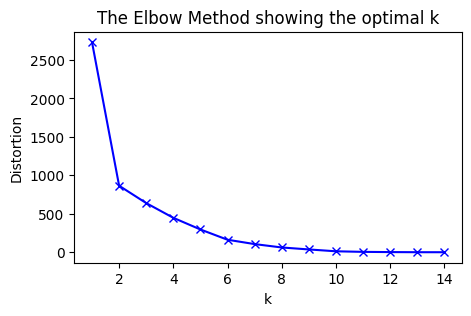

In [17]:
# Sum of squared distances of samples to their closest cluster center
distortions = []

# Range of k's
K = range(1,15)

# Loop to find the optimal k
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X3)
    distortions.append(kmeanModel.inertia_)
    
# Elbow plot
plt.figure(figsize=(5,3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

plt.show()

In the diagram, the elbow appears around k=3, suggesting that 3 clusters is a good choice for segmenting the wine data. This balances compactness within clusters and simplicity of the model.

### Perform k-means clustering on the wine data

In [18]:
# Number of clusters
k = 3

# Perform k-means clustering
kmeans_apmts = KMeans(n_clusters=k, random_state=42).fit(X3)

# Add the clusters to data frame
X3['cluster'] = kmeans_apmts.predict(X3)

# Show number of apartments per cluster
X3['cluster'].value_counts().sort_values(ascending=False)

cluster
1    160
2    100
0     40
Name: count, dtype: int64

This distribution indicates that most wines fall into Cluster 1, while Cluster 0 represents a smaller group. 

### Plot the wine clusters

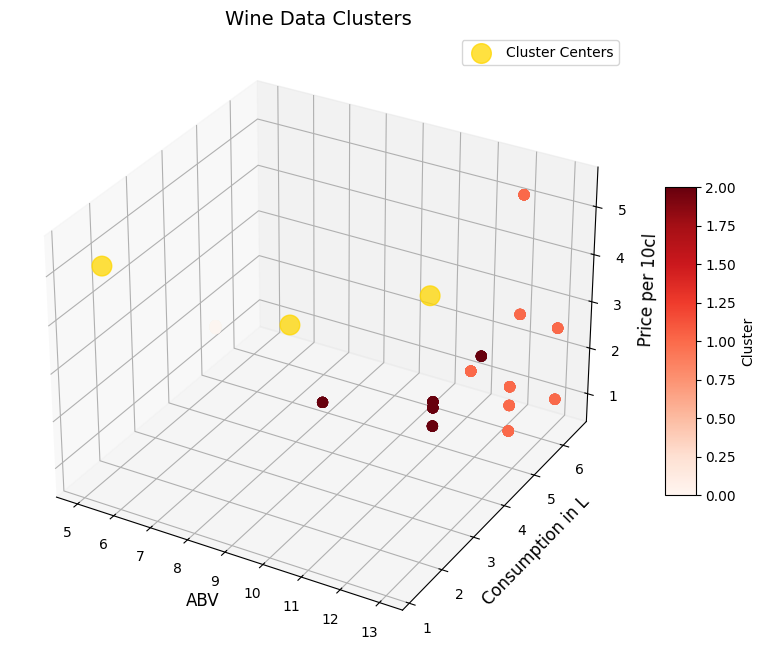

In [19]:
# Standardize the data for k-means clustering
scaler = StandardScaler()
X3_scaled = scaler.fit_transform(X3)

# Perform k-means clustering
k = 3  # Number of clusters
kmeans_apmts = KMeans(n_clusters=k, random_state=42).fit(X3_scaled)
X3['cluster'] = kmeans_apmts.labels_

# Plot the clusters in a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each point
scatter = ax.scatter(
    X3['ABV'], 
    X3['consumption_in_l'], 
    X3['price_per_10cl'], 
    c=X3['cluster'], 
    cmap='Reds', 
    s=50
)

# Add cluster centers to the plot
centers = scaler.inverse_transform(kmeans_apmts.cluster_centers_)
ax.scatter(
    centers[:, 0], 
    centers[:, 1], 
    centers[:, 2], 
    c='#FFD700', 
    s=200, 
    alpha=0.75, 
    label='Cluster Centers'
)

# Set title and axis labels
ax.set_title('Wine Data Clusters', fontsize=14)
ax.set_xlabel('ABV', fontsize=12)
ax.set_ylabel('Consumption in L', fontsize=12)
ax.set_zlabel('Price per 10cl', fontsize=12)

# Add legend and colorbar
plt.legend()
colorbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
colorbar.set_label('Cluster')

plt.show()

Cluster Centers (yellow points): One cluster includes wines with higher ABV and mid-to-high prices.
Another cluster groups wines with moderate ABV and lower prices.
The last cluster contains wines with low ABV, lower consumption, and lower prices.

### Calculate the Silhouette Score

In [20]:
# Calculate the silhouette score
silhouette_avg = silhouette_score(X3_scaled, kmeans_apmts.labels_)

# Print the silhouette score
print(f'Silhouette Score for k = {k}: {silhouette_avg}')

Silhouette Score for k = 3: 0.48729275556345386


A score closer to 1.0 would indicate distinct and well-defined clusters, while a score near 0 suggests overlapping clusters. This result supports that the clusters identified with k-means are meaningful but not perfectly distinct.

### Visualisation of Silhouette Score

Silhouette Score for k = 2: 0.4988864079623687
Silhouette Score for k = 3: 0.48729275556345386
Silhouette Score for k = 4: 0.5911731013741748
Silhouette Score for k = 5: 0.681869900045771
Silhouette Score for k = 6: 0.7296964715676587
Silhouette Score for k = 7: 0.7959536502410519
Silhouette Score for k = 8: 0.8590163830071335
Silhouette Score for k = 9: 0.900883528609323
Silhouette Score for k = 10: 0.9058904558899055


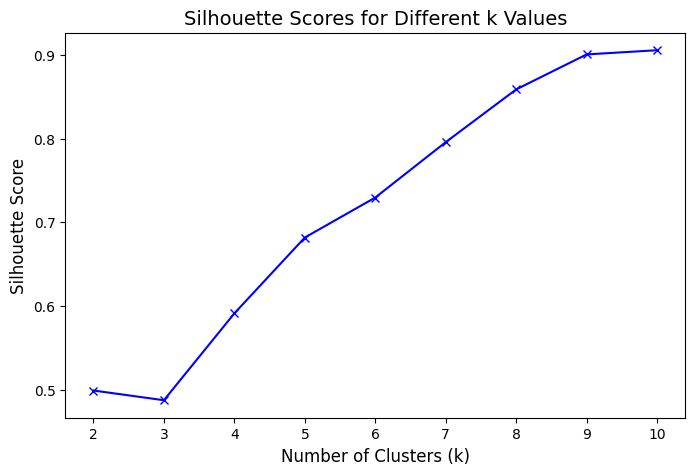

In [21]:
silhouette_scores = []
K = range(2, 11)  # Testing k values from 2 to 10

for k in K:
    kmeans_model = KMeans(n_clusters=k, random_state=42).fit(X3_scaled)
    labels = kmeans_model.labels_
    silhouette_avg = silhouette_score(X3_scaled, labels)
    silhouette_scores.append(silhouette_avg)
    print(f'Silhouette Score for k = {k}: {silhouette_avg}')

# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Scores for Different k Values', fontsize=14)
plt.show()


The Silhouette Score shows the quality of clustering. Higher scores mean better-defined clusters. For k=10, the score is highest (0.9), indicating the best clustering, while k=3 has a lower score (0.4), showing less optimal clustering.

### Jupyter notebook --footer info--

In [22]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Darwin | 24.1.0
Datetime: 2025-01-12 15:03:41
Python Version: 3.9.6
-----------------------------------
